In [223]:
%matplotlib inline

import pandas as pd
from pandas.tseries.offsets import MonthEnd

from sklearn.linear_model import LinearRegression, Lasso
import statsmodels.api as sm
# import statsmodels.formula.api as smf

import numpy as np
import matplotlib.pyplot as plt


# read data
p = 'C:\\Users\\nickb\\Documents\\FB\\Data Exercise.xlsx'
r = pd.read_excel(p, sheet_name="Roster")
t = pd.read_excel(p, sheet_name="Transfers")
f = pd.read_excel(p, sheet_name="Revenue").rename(columns={'REVENUE (000)':'revenue'})
cc_ids = r[['COST CENTER ID','COST CENTER NAME']].drop_duplicates(keep='first').reset_index(drop=True)

# helper functions

cc_names = r['COST CENTER NAME'].unique()
eng_names = ['Data Engineering','Engineeering'] # ,'Design','Product Management'  # ,
def get_hc_in_month(d,eng=False):
    """
    pass in a pd.Timestamp date (d), get the
    employee roster for that month
    
    eng: bool; if True, only return engineering headcounts
    """
    
    if eng:
        eng_add = (r['COST CENTER NAME'].isin(eng_names))
    else:
        eng_add = (True)
    
    criteria = (
                (
                    ((r['HIRE DATE']<=d) & (r['TERM DATE']>=d)) |   # active roster filter
                    ((r['HIRE DATE']<=d) & r['TERM DATE'].isnull())
                ) 
                & eng_add
               )
    
    return r[criteria]

def get_hires_in_month(d):
    """
    pass in a pd.Timestamp date (d), get the
    employee hires for that month
    """
    
    d_begin = d - MonthEnd(1) + pd.Timedelta(1, unit="D")  # hires since beginning on month
    
    criteria = ((r['HIRE DATE']>=d_begin) & (r['HIRE DATE']<=d))
    
    return r[criteria]


def get_departures_in_month(d):
    """
    pass in a pd.Timestamp date (d), get the
    employee departures for that month
    """
    
    d_begin = d - MonthEnd(1) + pd.Timedelta(1, unit="D")  # hires since beginning on month
    
    criteria = ((r['TERM DATE']>=d_begin) & (r['TERM DATE']<=d))
    
    return r[criteria]


def get_transfers_in_month(d):
    """
    pass in a pd.Timestamp date (d), get the
    employee transfers for that month
    """
    
    d_begin = d - MonthEnd(1) + pd.Timedelta(1, unit="D")  # hires since beginning on month
    
    criteria =  (
                      (t['COST CENTER BEFORE'] != t['COST CENTER AFTER'])
                    & (t['TRANSFER DATE']>=d_begin)
                    & (t['TRANSFER DATE']<=d)
                )
    
    return t[criteria]


# helper function
def r_squared_for_poly(x,y,model):
    """
    Calculate R^2 for polynomial models ( from np.poly1d(np.polyfit) )
    """
    
    yhat = model(x) # prediction
    ybar = np.sum(y) / len(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    
    return ssreg / sstot

def em_predictions(x,model):
    """
    Predictions for exponential fit (A*e^Bx)
    x: n.array of heads
    """
    
    B = model[0]
    A = model[1]
    
    return np.exp(A) * np.exp(B*x)


def em_predictions_reverse(y,model):
    """
    Reverse preds for exponential fit (A*e^Bx)
    y: np.array rev values
    """
    
    B = model[0]
    A = model[1]
    
    return (np.log(y) - A) / B

def poly_reverse_pred(y,pm):
    """
    y: np.array, revenue values to use to reverse predict hc
    pm: fitted poly model, that takes hc as X (input) 
    """
    pm_coeffs = pm.coefficients
    a = pm.coefficients[0]
    b = pm.coefficients[1]
    c = pm.coefficients[2]
    
    return (-b + np.sqrt((b**2)-4*a*(c-y)))/(2*a) # hc pred


def r_squared_for_exp(x,y,model):
    """
    Calculate R^2 for exponential models
    """
    
    yhat = em_predictions(x,model) # prediction
    ybar = np.sum(y) / len(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    
    return ssreg / sstot



# format data
f.loc[:,'date_month'] = pd.to_datetime({'year': f.YEAR,
                'month': f['MONTH NUMBER'],
                'day': [1] * f.shape[0]
               }).apply(lambda x: x + MonthEnd(0))  # assume revenue actuals / forecasts are for month end

t.loc[:,'COST CENTER BEFORE'] = t['COST CENTER BEFORE'].apply(lambda x: x[:x.find(" - ")])
t.loc[:,'COST CENTER AFTER'] = t['COST CENTER AFTER'].apply(lambda x: x[:x.find(" - ")])

# group by seniority
r.loc[:,'JOB LEVEL 2'] = r['JOB LEVEL'].map({'Junior Individual Contributor': 'Junior',
                                             'Seniior Individual Contributor': 'Senior',
                                             'Manager': 'Senior',
                                             'Director': 'Senior',
                                             'VP': 'VP',
                                            })
sen_names = r['JOB LEVEL 2'].unique()

# # re-label what appears to be spurious 'PAST' data to 'PROJECTION'
# criteria = (f.date_month >= pd.Timestamp(2017,8,31)) & (f.date_month <= pd.Timestamp(2018,1,31))
# f.loc[criteria,'TIME'] = 'PROJECTION'

projections = f[f.TIME=='PROJECTION'][['date_month','revenue']]
past_fin = f[f.TIME=='PAST'][['date_month','revenue']]

hc_cut_off = pd.Timestamp(2017,6,30)  
# get headcounts for each month
hc = pd.DataFrame({
        'date_month': f.date_month,
        'headcount': [get_hc_in_month(d).shape[0] if d<=hc_cut_off else 0 for d in f.date_month],
    })

# for model #2, capture headcount in engineering cost centers only (engineering + data engineering)
hc_eng = pd.DataFrame({
        'date_month': f.date_month,
        'headcount': [get_hc_in_month(d,eng=True).shape[0] if d<=hc_cut_off else 0 for d in f.date_month],
    })

# pivot tables of headcount, hires, departures, and transfers (in/out) by cost center and seniority
hc_by_cc = pd.concat([pd.DataFrame(get_hc_in_month(d).groupby('COST CENTER NAME')['EMPLOYEE NUMBER'].count()\
    .reindex(cc_names.tolist()).fillna(0))\
    .rename(columns={'EMPLOYEE NUMBER':d}) for d in f.date_month if d<=hc_cut_off],axis=1).T.fillna(0)

hc_by_sen = pd.concat([pd.DataFrame(get_hc_in_month(d).groupby('JOB LEVEL 2')['EMPLOYEE NUMBER'].count()\
    .reindex(sen_names.tolist()).fillna(0))\
    .rename(columns={'EMPLOYEE NUMBER':d}) for d in f.date_month if d<=hc_cut_off],axis=1).T.fillna(0)

hires_by_cc = pd.concat([pd.DataFrame(get_hires_in_month(d).groupby('COST CENTER NAME')['EMPLOYEE NUMBER'].count()\
    .reindex(cc_names.tolist()).fillna(0))\
    .rename(columns={'EMPLOYEE NUMBER':d}) for d in f.date_month if d<=hc_cut_off],axis=1).T.fillna(0)

departs_by_cc = pd.concat([pd.DataFrame(get_departures_in_month(d).groupby('COST CENTER NAME')['EMPLOYEE NUMBER'].count()\
    .reindex(cc_names.tolist()).fillna(0))\
    .rename(columns={'EMPLOYEE NUMBER':d}) for d in f.date_month if d<=hc_cut_off],axis=1).T.fillna(0)

departs_by_sen = pd.concat([pd.DataFrame(get_departures_in_month(d).groupby('JOB LEVEL 2')['EMPLOYEE NUMBER'].count()\
    .reindex(sen_names.tolist()).fillna(0))\
    .rename(columns={'EMPLOYEE NUMBER':d}) for d in f.date_month if d<=hc_cut_off],axis=1).T.fillna(0)

transfers_in_by_cc = pd.concat([pd.DataFrame(get_transfers_in_month(d).groupby('COST CENTER AFTER')['EMPLOYEE ID'].count())\
    .reset_index()\
    .join(cc_ids.set_index('COST CENTER ID'), on='COST CENTER AFTER')[['COST CENTER NAME','EMPLOYEE ID']]\
    .set_index('COST CENTER NAME')\
    .reindex(cc_names.tolist()).fillna(0)\
    .rename(columns={'EMPLOYEE ID':d}) for d in f.date_month if d<=hc_cut_off],axis=1).T.fillna(0)

transfers_out_by_cc = pd.concat([pd.DataFrame(get_transfers_in_month(d).groupby('COST CENTER BEFORE')['EMPLOYEE ID'].count())\
    .reset_index()\
    .join(cc_ids.set_index('COST CENTER ID'), on='COST CENTER BEFORE')[['COST CENTER NAME','EMPLOYEE ID']]\
    .set_index('COST CENTER NAME')\
    .reindex(cc_names.tolist()).fillna(0)\
    .rename(columns={'EMPLOYEE ID':d}) for d in f.date_month if d<=hc_cut_off],axis=1).T.fillna(0)

# avg composition of headcount (by cost center); assume current composition (on or after 1/1/2016)
composition = hc_by_cc.div(hc_by_cc.sum(axis=1),axis=0).fillna(0.0)
composition = composition.loc[composition.index>=(pd.Timestamp(2016,1,1))].mean()

# departures, transfers (in/out) as % of avg. hc (12-mo rolling) by cc
# use only last three years of data for stats
cut_off2 = pd.Timestamp(2015,1,1)

mo_depart_prcnt_by_cc = departs_by_cc.rolling(12).sum() / hc_by_cc.rolling(12).mean()
mo_depart_prcnt_by_cc = (mo_depart_prcnt_by_cc.loc[mo_depart_prcnt_by_cc.index>=cut_off2,:].mean()/12.0)

mo_depart_prcnt_by_sen = departs_by_sen.rolling(12).sum() / hc_by_sen.rolling(12).mean()
mo_depart_prcnt_by_sen = (mo_depart_prcnt_by_sen.loc[mo_depart_prcnt_by_sen.index>=cut_off2,:].mean()/12.0)

mo_transfers_in_prcnt_by_cc = transfers_in_by_cc.rolling(12).sum() / hc_by_cc.rolling(12).mean()
mo_transfers_in_prcnt_by_cc = (mo_transfers_in_prcnt_by_cc.loc[mo_transfers_in_prcnt_by_cc.index>=cut_off2,:].mean()/12.0)

mo_transfers_out_prcnt_by_cc = transfers_out_by_cc.rolling(12).sum() / hc_by_cc.rolling(12).mean()
mo_transfers_out_prcnt_by_cc = (mo_transfers_out_prcnt_by_cc.loc[mo_transfers_out_prcnt_by_cc.index>=cut_off2,:].mean()/12.0)




# ignore 1/2005 to 11/2005 where no employee headcount is measured
hc = hc[hc.headcount!=0]
hc_eng = hc_eng[hc_eng.headcount!=0]

# add missing headcounts for 7/31/2017 to current date 1/31/2018
# due to what appears to be old roster data.
# Method for filling missing values: fit linear model to historical data (starting in 2012), extrapolate to require dates 
def infer_hc(df, start_date=None, end_date=None, min_date_for_fit=None, method='linear'):
    """
    df = headcount frame (hc hc_eng, etc.)
    min_date_for_fit = minimum date to use for model fit
    start_date = start date for prediction
    end_date = start date for prediction
    method = 'linear' or 'poly' (fit linear model or polynomial model)
    """    
    if min_date_for_fit==None:
        min_date_for_fit = pd.Timestamp(2012,1,1)
        
    if start_date==None:
        start_date = pd.Timestamp(2017,7,31)
    
    if end_date==None:
        end_date = pd.Timestamp(2018,1,31)
        
    x_vals = df[df.date_month>=min_date_for_fit].date_month.apply(lambda x: x.value).values
    y_vals = df[df.date_month>=min_date_for_fit].headcount
    hc_x_vals = pd.Series(pd.date_range(start=start_date,end=end_date, freq='M'))
    
    if method == 'linear':
        lm = LinearRegression()
        X = np.reshape(x_vals,(-1,1))
        y = np.reshape(y_vals,(-1,1))

        lm.fit(X,y)
        heads_extrap = np.reshape(lm.predict(np.reshape(hc_x_vals.apply(lambda x: x.value),(-1,1))),(1,-1))[0]
            
    if method == 'poly':
        pm = np.poly1d(np.polyfit(x_vals,y_vals,2)) # polynomial setup + fit
        heads_extrap = pm(hc_x_vals.apply(lambda x: x.value))
    
    new_heads = pd.concat([hc_x_vals,pd.Series(heads_extrap).astype(int)],axis=1).rename(columns={0:'date_month',1:'headcount'})

    
    return pd.concat([df,new_heads]).reset_index(drop=True)



hc = infer_hc(hc, method='poly', min_date_for_fit = pd.Timestamp(2009,1,1))
hc_eng = infer_hc(hc_eng, method='poly', min_date_for_fit = pd.Timestamp(2009,1,1))

# Add inferred headcounts to each cc (inferred using method 1 [tl1] and method 2[tl2])
hc_by_cc_tl1 = pd.concat([hc_by_cc,pd.concat([h*composition for h in hc.tail(7).headcount.values],axis=1)\
    .rename(columns={i:d for i,d in zip(range(0,7),hc.tail(7).date_month)}).T])
hc_by_cc_tl2 = pd.concat([
            hc_by_cc,
            pd.concat(
                [(h/composition[composition.index.isin(eng_names)].sum())*composition for h in hc_eng.tail(7).headcount.values]
                ,axis=1)\
           .rename(columns={i:d for i,d in zip(range(0,7),hc.tail(7).date_month)}).T]).tail(10)

# join headcount data to financial data
f = f\
    .join(hc.set_index('date_month').headcount, on='date_month')\
    .join(hc_eng.set_index('date_month').headcount, on='date_month', rsuffix='_eng')



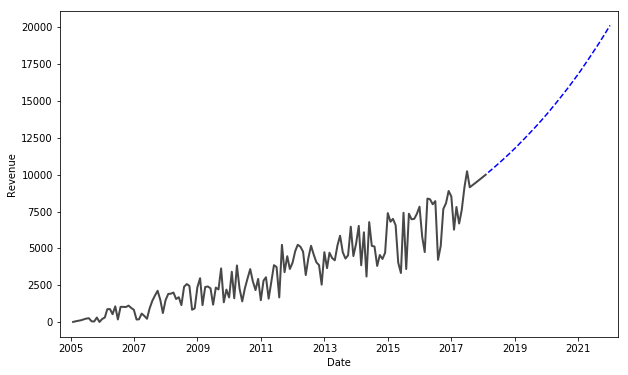

In [224]:
# plot of revenue data
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(past_fin.date_month, pd.Series(past_fin.revenue).rolling(1).mean(), color="#484848", lw=2)
ax.plot(projections.date_month, pd.Series(projections.revenue).rolling(1).mean(), color="blue", ls="--")
ax.set_xlim(pd.Timestamp(2004,8,31), pd.Timestamp(2022,3,31))
ax.set_xlabel("Date")
ax.set_ylabel("Revenue")

fig.savefig('C:\\Users\\nickb\\Documents\\FB\\revenue_historical_and_projection.svg')

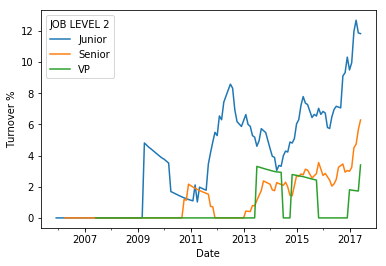

In [225]:
departs_by_sen.tail()
hc_by_sen.tail()
ax = (100. * departs_by_sen.rolling(12).sum() / hc_by_sen.rolling(12).mean()).plot.line()
ax.set_xlabel("Date")
ax.set_ylabel("Turnover %")
ax.get_figure().savefig('C:\\Users\\nickb\\Documents\\FB\\turnover_by_sen.svg')

In [226]:
hc_by_sen.rolling(12).sum().divide(hc_by_sen.rolling(12).sum().sum(axis=1), axis=0)

JOB LEVEL 2,Junior,Senior,VP
2005-01-31,NaN,NaN,NaN
2005-02-28,NaN,NaN,NaN
2005-03-31,NaN,NaN,NaN
2005-04-30,NaN,NaN,NaN
2005-05-31,NaN,NaN,NaN
2005-06-30,NaN,NaN,NaN
2005-07-31,NaN,NaN,NaN
2005-08-31,NaN,NaN,NaN
2005-09-30,NaN,NaN,NaN
2005-10-31,NaN,NaN,NaN


In [227]:
departs_by_sen.tail()

JOB LEVEL 2,Junior,Senior,VP
2017-02-28,5.0,3.0,0.0
2017-03-31,8.0,9.0,0.0
2017-04-30,5.0,3.0,0.0
2017-05-31,1.0,8.0,0.0
2017-06-30,3.0,6.0,1.0


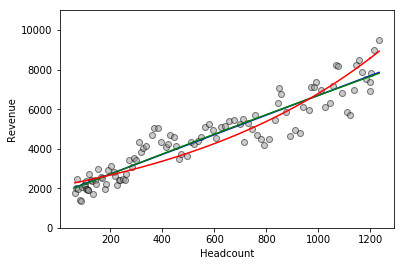

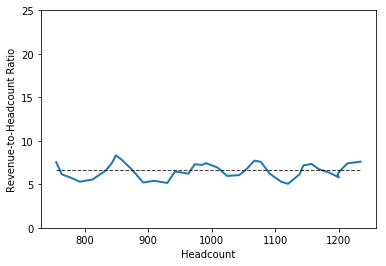

In [228]:
"""
Test for correlation between headcount and revenue:
    - linear model (ordinary least squares + Lasso)
    - polynomial
    - exponential
"""

roll_window = 3 # when calculating rolling metrics, assume X number of months
center = True

f.loc[:,'revenue_roll_avg'] = f.revenue.rolling(roll_window, center=center).mean()
f.loc[:,'headcount_roll_avg'] = f.headcount.rolling(roll_window, center=center).mean()
f.loc[:,'headcount_eng_roll_avg'] = f.headcount_eng.rolling(roll_window, center=center).mean()
f.loc[:,'revenue_per_head'] = f.revenue_roll_avg / f.headcount_roll_avg


# simple plots for testing / analysis
# hc.plot.line(x='date_month',y='headcount')
# f[~f.revenue_roll_avg.isnull()].plot.line(x='headcount', y='revenue_roll_avg')
# fig, ax = plt.subplots() # figsize=(15,10)
# ax.plot(hc[hc.date_month<=pd.datetime(2017,6,30)].date_month, hc[hc.date_month<=pd.datetime(2017,6,30)].headcount, color='blue')
# ax.plot(hc[hc.date_month>pd.datetime(2017,6,30)].date_month, hc[hc.date_month>pd.datetime(2017,6,30)].headcount, color='red')


# prep input data
# don't include hc extrapolation in modeling
f = f.sort_values('date_month')
criteria = (
                  (~f.revenue_roll_avg.isnull())
                & (~f.headcount.isnull())
                & (f.date_month <= pd.Timestamp(2017,6,30))                # don't use extrapolated hc  # hc_cut_off
                & (f.date_month >= pd.Timestamp(2008,6,30))  # use past 8 of data for inference (when company had >= 200 hc)

            )

c1 = pd.Timestamp(2014,6,30)
c2 = pd.Timestamp(2017,6,30)
fin_criteria = (
                    (f.date_month>=c1)
                    & (f.date_month<=c2)
                    & (~f.revenue_per_head.isnull())
                    & (~f.headcount.isnull())
                )

# simple plots
# f[f.date_month>=c1].plot.line(x='date_month',y='revenue_per_head')

x_vals = f[criteria].headcount.values
x_vals_eng = f[criteria].headcount_eng.values
x_vals_fin = f[fin_criteria].headcount.values
y_vals = f[criteria].revenue_roll_avg.values
y_vals_fin = f[fin_criteria].revenue_per_head.values

X = np.reshape(x_vals, newshape=(len(x_vals),1))
X_eng = np.reshape(x_vals_eng, newshape=(len(x_vals),1))
X_fin = np.reshape(x_vals_fin, newshape=(len(x_vals_fin),1))
y = np.reshape(y_vals, newshape=(len(y_vals),1))
y_fin = np.reshape(y_vals_fin, newshape=(len(y_vals_fin),1))

# setup regression models

lm = LinearRegression()
lm_eng = LinearRegression()
pm = np.poly1d(np.polyfit(x_vals,y_vals,2)) # polynomial setup + fit
em = np.polyfit(x_vals,np.log(y_vals),1) # exponential setup + fit

# fit models
lm.fit(X,y)
lm_eng.fit(X_eng,y)
lm2_fin = sm.OLS(y_fin, sm.add_constant(X_fin))
lm2 = sm.OLS(y, sm.add_constant(X))
lm2_eng = sm.OLS(y, sm.add_constant(X_eng))

# get model predictions
lm_predict = lm.predict(X)
lm_predict_eng = lm_eng.predict(X_eng)
lm2_results = lm2.fit()
lm2_results_eng = lm2_eng.fit()
lm2_results_fin = lm2_fin.fit()

# # plot headcount vs. revenue data and models
fig, ax = plt.subplots() # figsize=(15,10)
ax.scatter(x_vals, y_vals, color="#989898", edgecolor=(0,0,0), alpha=0.5)
ax.plot(x_vals, lm_predict, color='blue')
ax.plot(x_vals, pm(x_vals), color='green')
ax.plot(x_vals, em_predictions(x_vals,em), color='red')
ax.set_ylim(0,11000)
ax.set_xlabel('Headcount')
ax.set_ylabel('Revenue')
# ax.set_alpha(0.5)
fig.savefig('C:\\Users\\nickb\\Documents\\FB\\head_to_rev_scatter_with_fits.svg')

fig_fin, ax_fin = plt.subplots() # figsize=(15,10)
ax_fin.plot(f[fin_criteria].headcount.values, f[fin_criteria].revenue_per_head.values, lw=2)
ax_fin.plot(f[fin_criteria].headcount.values, [6.7]*f[fin_criteria].shape[0], alpha=0.75, color='black', lw=1, ls="--")
ax_fin.set_ylim(0,25)
ax_fin.set_xlabel('Headcount')
ax_fin.set_ylabel('Revenue-to-Headcount Ratio')
fig_fin.savefig('C:\\Users\\nickb\\Documents\\FB\\head_to_rev_ratio.svg')





In [229]:
mean_fin = f[fin_criteria].revenue_per_head.mean()
std = f[fin_criteria].revenue_per_head.std()

print mean_fin
print mean_fin-1*std, mean_fin+1*std



6.55486913086
5.6719263395 7.43781192221


In [230]:
lm2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     803.9
Date:                Mon, 12 Mar 2018   Prob (F-statistic):           1.42e-51
Time:                        13:26:47   Log-Likelihood:                -864.70
No. Observations:                 109   AIC:                             1733.
Df Residuals:                     107   BIC:                             1739.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1727.6724    117.235     14.737      0.000    1495.268    1960.077
x1             4.9718      0.175     28.354      0.000       4.624       5.319
==============================================================================
Omnibus:                        0.327   Durbin-Watson:                   0.697
Prob(Omnibus):                  0.849   Jarque-Bera (JB):                0.148
Skew:                          -0.087   Prob(JB):                        0.929
Kurtosis:                       3.047   Cond. No.                     1.20e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

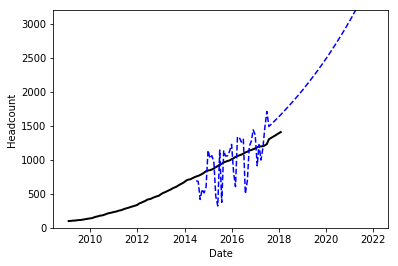

In [235]:
# total HC model
lm1_params = {
    'M': lm2_results.params[1],
    'b': lm2_results.params[0],
}

lm2_params = {
    'M': 6.691,
    'b': 1071.2,
}

# sanity check: historical revenue increase when headcount increases by factor of X
# multiplier = 2.0
# dbl = f.groupby(['date_month','headcount_roll_avg','revenue_roll_avg']).apply(lambda x: 
#                               f[
#                                   (f.headcount_roll_avg > (multiplier*x.headcount_roll_avg.values[0])-10) & 
#                                   (f.headcount_roll_avg < (multiplier*x.headcount_roll_avg.values[0])+10)
#                               ][['date_month','revenue_roll_avg','headcount_roll_avg']].head(1))\
#         .rename(columns={'date_month':'date_month_dbl','revenue_roll_avg':'revenue_roll_avg_dbl','headcount_roll_avg':'headcount_roll_avg_dbl'})\
#         .reset_index()

# dbl.loc[:,'rev_change'] = dbl.revenue_roll_avg_dbl / dbl.revenue_roll_avg
# criteriazzz = (dbl.date_month>=pd.Timestamp(2012,1,1))
# dbl[criteriazzz].plot.line(x='headcount_roll_avg',y='rev_change')
# mean = dbl[criteriazzz].rev_change.mean()
# median = dbl[criteriazzz].rev_change.median()
# std = dbl[criteriazzz].rev_change.std()


# h_low = hc[hc.date_month==pd.Timestamp(2018,1,31)].headcount.values[0]
# h_high = h_low*multiplier
# Y1 = lm1_params['M']*h_low + lm1_params['b']
# Y2 = lm1_params['M']*h_high + lm1_params['b']
# print "When headcount increases by ", str(multiplier)+"X", "model predicts revenue increases by:", 1.0*Y2/Y1
# print "Historically, this multiplication has resulted in the following revenue multipliers:"
# print 'mean/median/std',mean,median,std
# print '61% CFI:',mean-std,mean+std
# print '80% CFI:',mean-1.5*std,mean+1.5*std





eng_comp = composition[composition.index.isin(eng_names)].sum()
projections.loc[:,'projected_hc_lm1'] = projections.revenue.apply(lambda x: (x-lm1_params['b'])/lm1_params['M'])
projections.loc[:,'projected_hc_lm2'] = projections.revenue.apply(lambda x: ((x-lm2_params['b'])/lm2_params['M'])/eng_comp)

roll_window2 = 1
center = True
hc_preds_overall = pd.concat([f.date_month,
                                   f.revenue.rolling(roll_window2, center=center).mean()\
                                       .apply(lambda x: (x-lm1_params['b'])/lm1_params['M'])
                                  ], axis=1).rename(columns={'revenue':'headcount'})
min_graph_date = pd.Timestamp(2009,1,1)
hc_preds_overall = hc_preds_overall[hc_preds_overall.date_month>=min_graph_date]

# force-fit predictions which adhere to desired rev/employee rate
rate = 6.6
ccc = pd.Timestamp(2018,2,28)
ddd = pd.Timestamp(2021,12,31)
f2 = f[(f.date_month>=ccc) & (f.date_month<=ddd)]
hc_preds_overall2 = hc_preds_overall[(hc_preds_overall.date_month>=ccc) & (hc_preds_overall.date_month<=ddd)]
rev_per_emp = f2.revenue / hc_preds_overall2.headcount
hc_preds_overall_ff = pd.DataFrame(data={
        'date_month': f2.date_month.values,
        'headcount': [phc*(rev/(rate*phc)) if rpe>rate else np.nan
                       for d,rev,rpe,phc in zip(f2.date_month, f2.revenue, rev_per_emp, hc_preds_overall2.headcount)]
        })

hc_preds_overall_ff2 = (hc_preds_overall[hc_preds_overall.date_month>=ccc].set_index('date_month')\
    .add(hc_preds_overall_ff[hc_preds_overall_ff.date_month>=ccc].set_index('date_month')) / 2.0).reset_index()
 
    
fig, ax = plt.subplots()
ax.set_ylim(0,3200)
ax.set_xlabel('Date')
ax.set_ylabel('Headcount')
# historical headcount
ax.plot(hc[hc.date_month>=min_graph_date].date_month, hc[hc.date_month>=min_graph_date].headcount, color='black', lw=2)
# linear model history
# ax.plot(hc_preds_overall[hc_preds_overall.date_month<=pd.Timestamp(2018,1,31)].date_month, 
#         hc_preds_overall[hc_preds_overall.date_month<=pd.Timestamp(2018,1,31)].headcount, color='blue', ls="-")
# linear model forecast
ax.plot(hc_preds_overall[hc_preds_overall.date_month>=pd.Timestamp(2014,6,30)].date_month, 
        hc_preds_overall[hc_preds_overall.date_month>=pd.Timestamp(2014,6,30)].headcount, color='blue', ls="--")
# ax.plot(hc_preds_overall_ff.date_month, hc_preds_overall_ff.headcount, color='red', ls="--")
# ax.plot(hc_preds_overall_ff2.date_month, hc_preds_overall_ff2.headcount, color='blue', ls="--")


# bad models
bad_model_cut = pd.Timestamp(2018,1,31)
# ax.plot(f[f.date_month>=bad_model_cut].date_month, 
#         poly_reverse_pred(f[f.date_month>=bad_model_cut].revenue_roll_avg.rolling(roll_window2, center=center).mean(), pm),\
#         color='green', ls="--")
# ax.plot(f[f.date_month>=bad_model_cut].date_month, 
#         em_predictions_reverse(f[f.date_month>=bad_model_cut].revenue_roll_avg.rolling(roll_window2, center=center).mean(), em),\
#         color='red', ls="--")


fig.savefig('C:\\Users\\nickb\\Documents\\FB\\initial_models.svg')

In [236]:


# numer = f[(f.date_month>=pd.Timestamp(2018,1,31)) & (f.date_month<=pd.Timestamp(2021,12,31))].revenue_roll_avg

# denom = hc_preds_overall[hc_preds_overall.date_month>=pd.Timestamp(2018,1,31)].headcount

# all_data = (numer / denom)
# mean = all_data.mean()
# std = all_data.std()

# print mean
# print mean-1.0*std, mean+1.0*std

# # all_data

# # em_predictions_reverse(f[f.date_month>=bad_model_cut].revenue_roll_avg.rolling(roll_window2, center=center).mean(), em)

# hc_preds_overall[hc_preds_overall.date_month>=pd.Timestamp(2018,1,31)].head()

In [237]:
def get_hire_by_month_rec2(df, ac, window=3):
    """
    df = frame; hc predictions by cc
    ac = frame; hc actuals by cc
    p = frame; financials projections (see var 'projections')
    ff = float; force fit hires to a specified R2H value; if None, don't force fit
    window = int; number of months for inference
    """   
    
    # get hire recs for future dates
    departures = df.multiply(mo_depart_prcnt_by_cc)
    transfers_in = df.multiply(mo_transfers_in_prcnt_by_cc)
    transfers_out = df.multiply(mo_transfers_out_prcnt_by_cc)  
    hires = df.shift(-1) - (df + transfers_in - transfers_out - departures) # shift(-1) => next month's hc goal
    
    # add 'topper' row to frame (accounts for any disconnect between actual and projected hc)
    ac_df = ac.tail(1)
    departures = ac_df.multiply(mo_depart_prcnt_by_cc)
    transfers_in = ac_df.multiply(mo_transfers_in_prcnt_by_cc)
    transfers_out = ac_df.multiply(mo_transfers_out_prcnt_by_cc)

    next_hc = ac_df + transfers_in - transfers_out - departures
    next_hc.index = next_hc.index.shift(1, freq='M')
    
    topper = pd.DataFrame(df.loc[next_hc.index.values[0]]).T - next_hc
    
    o = pd.concat([topper, hires.tail(-1)]).fillna(1)
   
    # if req'd, infer any hires for missing future
    # months due to rolling metrics
    for x in range(1,10):
        last_good_date = o.index[-x]
        if o.tail(x).head(1).iloc[0,0] != 1.0:
            last_good_date = o.index[-x]
            o = o[o.index<=last_good_date]
            break
                        
    max_date = pd.Timestamp(2021,12,31)
    for d in pd.date_range(start=(last_good_date+MonthEnd(1)), end=max_date, freq="M"):
        o.loc[d,:] = o.tail(1).values[0] + (o.tail(1).subtract(o.tail(window).head(1).values,axis=1) / (window-1)).values[0]    
        
    return o

     

In [241]:
hc_pred_by_cc = pd.concat([pd.DataFrame(composition*r.headcount).rename(columns={0:r.date_month})
                for i,r in hc_preds_overall[hc_preds_overall.date_month>=pd.Timestamp(2018,2,1)].iterrows()],
          axis=1).T
    
# force fit (conform prediction results to a specified R2H)
ff = 7.4
hc_preds_overall_ff = hc_preds_overall.join(projections.set_index('date_month').revenue, on='date_month')
hc_preds_overall_ff.loc[:,'headcount'] = hc_preds_overall_ff.headcount * \
    (hc_preds_overall_ff.revenue / (ff * hc_preds_overall_ff.headcount))
hc_preds_overall_ff.drop(columns=['revenue'])
hc_pred_by_cc_ff = pd.concat([pd.DataFrame(composition*r.headcount).rename(columns={0:r.date_month})
                for i,r in hc_preds_overall_ff[hc_preds_overall_ff.date_month>=pd.Timestamp(2018,2,1)].iterrows()],
          axis=1).T


rhc = int(hc_preds_overall_ff.tail(1).headcount.values[0])
ch = hc.tail(1).headcount.values[0]
rhires = get_hire_by_month_rec2(hc_pred_by_cc_ff, hc_by_cc_tl1)
print 'required total headcount by end date:', rhc
print 'current headcount:', ch
print "net new headcount req't by end date:", rhc-ch, "(",round(float(rhc)/ch,3), "increase in size)"
print "req'd hires to meet total hc by end:", int(rhires.sum().sum())


required total headcount by end date: 2720
current headcount: 1409
net new headcount req't by end date: 1311 ( 1.93 increase in size)
req'd hires to meet total hc by end: 1704


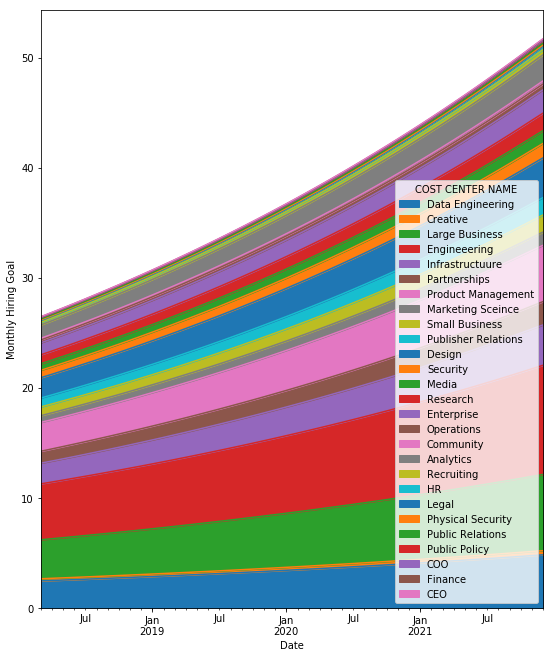

In [242]:
ax = rhires[rhires.index>=pd.Timestamp(2018,3,31)].plot.area(figsize=(9,11), 
                                                     xlim=(pd.Timestamp(2018,3,31),pd.Timestamp(2021,12,31)))
ax.set_xlabel("Date")
ax.set_ylabel("Monthly Hiring Goal")

ax.get_figure().savefig('C:\\Users\\nickb\\Documents\\FB\\hires_by_cc.svg')

In [240]:
r2 = r
r2.columns = ["_".join(c.replace("(","").replace(")","").split()) for c in r2.columns]
r2.loc[:,'EDUCATION_LEVEL'] = r2['EDUCATION_LEVEL'].apply(lambda x: x.replace("'",""))

# r2.to_csv('C:\\Users\\nickb\\Documents\\FB\\roster_only.csv', index=False)

r2.EDUCATION_LEVEL.unique()

AttributeError: 'Series' object has no attribute 'columns'

In [ ]:
r['DISTANCE FROM HOME (MILES)'].plot.hist(bins=20)

In [ ]:
from sklearn.datasets import load_iris
from sklearn.externals.six import StringIO  
from sklearn import tree

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix


import graphviz
import pydot

import os

# must add file path of graphviz dot.exe and 
# other dependencies to PATH env var
p = "C:\\Users\\nickb\\AppData\\Local\\Continuum\\anaconda2\\pkgs\\graphviz-2.38.0-4\\Library\\bin\\graphviz\\"
os.environ["PATH"] += os.pathsep + p

r = pd.read_excel('C:\\Users\\nickb\\Documents\\FB\\Data Exercise.xlsx', sheet_name="Roster")
r = r[r['TERM DATE'].isnull()]  # only current staff

# attempts at feature engineering
r.loc[:,'RETIREMENT'] = r['AGE IN YEARS'].apply(lambda x: 'Retirement Age' if x>=65 else 'Not Retirement Age')
r.loc[:,'WORK LOCATION 2'] = r['WORK LOCATION'].map({'Building 18':'HQ','HQ - Downtown':'HQ','HQ -  Satelite Campus':'Satelite'})
r.loc[:,'DISTANCE_FROM_HOME2'] = [('LOW' if d <=1 else ('MED' if d<15 else 'HIGH')) for d in r['DISTANCE FROM HOME (MILES)']]
r.loc[:,'JOB LEVEL 2'] = r['JOB LEVEL'].map({
    'Junior Individual Contributor': 'junior',
    'Seniior Individual Contributor': 'senior',
    'Manager': 'senior',
    'Director': 'senior',
    'VP': 'VP'
})
r.loc[:,'HOURLY RATE BIN'] = pd.cut(r['HOURLY RATE (USD)'], range(0,110,10))
r.loc[:,'WORK LIFE BALANCE 2'] = r['WORK LIFE BALANCE'].apply(lambda x: 'Poor' if x=='Poor' else 'Good')



# input columns with categorical and continuous data
input_cols_cat = ['WORK LOCATION','EDUCATION LEVEL','WORK ENVIRONMENT SATISFACTION','JOB ROLE INVOLVEMENT',
                 'JOB LEVEL','WORK LIFE BALANCE','PERFORMANCE RATING','WORK RELATED TRAVEL','OVER TIME','RETIREMENT',
                 'WORK LOCATION 2','DISTANCE_FROM_HOME2','JOB LEVEL 2','HOURLY RATE BIN','WORK LIFE BALANCE 2',
                 'COMPANIES WORKED BEFORE','TRAININGS ATTENDED IN LAST 365 DAYS','YEARS SINCE LAST PROMOTION']

input_cols_cont = ['DISTANCE FROM HOME (MILES)','HOURLY RATE (USD)','COMPANIES WORKED BEFORE',
                   'TRAININGS ATTENDED IN LAST 365 DAYS','YEARS SINCE LAST PROMOTION']
target_col = 'JOB SATISFACTION'
inputs = []  # holds all pre-processed input variables for model

# convert categorical data to int-encoding (input and target variables)
enc_t = LabelEncoder()
enc_t.fit(r[target_col].values)
target = r['JOB SATISFACTION'].map({
                                    'Not Satisfied': 1,
                                    'Somewhat Satisfied': 0,
                                    'Satisfied': 0,
                                    'Highly Satisfied': 0,  
                                }).values

enc_in = {}
for col in input_cols_cat:
    enc = LabelEncoder()
    enc_in[col] = enc  # save LabelEncoder for future reverse transforms
    
    if r[col].isnull().sum() == 0:  # fill any NaN
        to_trnx = r[col].values
    else:
        to_trnx = r[col].fillna('FILLER').values
    
    enc.fit(to_trnx)
    txdata = enc.transform(to_trnx)
    
    inputs.append(txdata)
    
# format continuous variables
for col in input_cols_cont:
    if r[col].isnull().sum()>0:
        inputs.append(r[col].fillna(0).values)
    else:
        inputs.append(r[col].values)
        
        
        
# initialize model with parameters
random_state = None #79512379
max_depth = None
min_samples_leaf = 2
min_samples_split = 2
max_leaf_nodes = None ##100
min_impurity_decrease = 0 #.001

clf = tree.DecisionTreeClassifier(min_samples_split=min_samples_split,
                                 criterion='gini',
                                 random_state=random_state,
                                 min_impurity_decrease=min_impurity_decrease,
                                 max_depth=max_depth,
                                 min_samples_leaf=min_samples_leaf,
                                 max_leaf_nodes=max_leaf_nodes)
clf2 = tree.DecisionTreeClassifier(min_samples_split=min_samples_split,
                                   criterion='entropy',
                                  random_state=random_state,
                                  min_impurity_decrease=min_impurity_decrease,
                                  max_depth=max_depth,
                                  min_samples_leaf=min_samples_leaf,
                                  max_leaf_nodes=max_leaf_nodes)
    
# split data into training/test arrays and fit model
X = np.array(inputs).T
tp_results = []
tp_results2 = []
tp_percent = []

for x in range(0,200):
    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.1, random_state=None, shuffle=True)
    clf = clf.fit(X_train, y_train)
    clf2 = clf2.fit(X_train, y_train)

    # test models accuracy via confusion matrix
    y_pred = clf.predict(X_test)
    y_pred2 = clf2.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cm2 = confusion_matrix(y_test, y_pred2)
    tn, fp, fn, tp = cm.ravel()
    tn2, fp2, fn2, tp2 = cm2.ravel()
    
    tp_results.append(100.*tp / (tp+fn))
    tp_results2.append(100.*tp2 / (tp2+fn2))
    
    tp_percent.append(100.*y_test.sum() / float(y_test.shape[0]))
    
    
print 'Percent in Testing Data: ', np.array(tp_percent).mean()
print 'Model 1 Avg TP rate: ', np.array(tp_results).mean()
print 'Model 2 Avg TP rate: ', np.array(tp_results2).mean()
    
    
    

# print "Percent Not Satisfied in Testing Data: {0:.2f}% \n".format(y_test.sum() / float(y_test.shape[0]))

# print tp, fp
# print fn, tn
# print 'True Positive Rate (Recall / "Hit Rate"): {0:.2f}%'.format(100.*tp / (tp+fn))
# print 'True Negative Rate: {0:.2f}%'.format(100.0*tn / (tn+fp))
# print 'False Positive Rate (Type I Error / "False Alarm"): {0:.2f}%'.format(100.*fp / (fp+tn))
# print 'False Negative Rate (Type II Error / "Miss Rate"): {0:.2f}%'.format(100.0*fn / (fn+tp))

# print "\n"
# print tp2, fp2
# print fn2, tn2
# print 'True Positive Rate (Recall / "Hit Rate"): {0:.2f}%'.format(100.*tp2 / (tp2+fn2))
# print 'True Negative Rate: {0:.2f}%'.format(100.0*tn2 / (tn2+fp2))
# print 'False Positive Rate (Type I Error / "False Alarm"): {0:.2f}%'.format(100.*fp2 / (fp2+tn2))
# print 'False Negative Rate (Type II Error / "Miss Rate"): {0:.2f}%'.format(100.0*fn / (fn2+tp2))


dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data, feature_names=input_cols_cat + input_cols_cont)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
graph[0].write_pdf("iris.pdf")

In [221]:
prec2 = 1.*tp2 / (tp2+fp2)

2. / ((1./tp2) + (1./prec2))

0.6206896551724138

In [218]:
print tp2, fp2
print fn2, tn2

9 19
14 82


In [59]:
confusion_matrix(y_test, y_pred).ravel()

array([155,  43,  76,  20], dtype=int64)

In [ ]:
r['JOB SATISFACTION'].value_counts() #unique() # .apply(lambda x: 'Poor' if x=='Poor' else 'Good')

In [ ]:
461. / r['JOB SATISFACTION'].value_counts().sum()

In [118]:
r.head()

,EMPLOYEE NUMBER,AGE IN YEARS,HIRE DATE,TERM DATE,ORG,COST CENTER ID,COST CENTER NAME,WORK LOCATION,DISTANCE FROM HOME (MILES),EDUCATION LEVEL,...,PERFORMANCE RATING,WORK RELATED TRAVEL,COMPANIES WORKED BEFORE,WORK HOURS,TRAININGS ATTENDED IN LAST 365 DAYS,YEARS IN CURRENT JOB ROLE,YEARS SINCE LAST PROMOTION,YEARS WITH CURRENT MANAGER,OVER TIME,JOB LEVEL 2
0,2603,44,2012-01-05,NaT,Tech,CC020,Data Engineering,Building 18,4,Below College,...,Exceeds Expectations,Rare Travel,7.0,60,3.0,0,3,0,No,Junior
1,440,54,2016-12-14,NaT,GMS,CC025,Creative,HQ - Downtown,20,Bachelor's,...,Exceeds Expectations,Frequent Travel,6.0,60,2.0,0,0,0,No,Senior
2,273,48,2013-06-21,NaT,GMS,CC010,Large Business,HQ - Downtown,4,Master's,...,Exceeds Expectations,Rare Travel,9.0,60,1.0,1,1,0,No,Senior
3,2840,35,2014-07-01,NaT,Tech,CC019,Engineeering,HQ - Downtown,1,College,...,Exceeds Expectations,Rare Travel,2.0,60,3.0,1,1,3,Yes,Junior
4,1829,38,2011-02-06,2011-05-01,Tech,CC019,Engineeering,HQ - Downtown,17,College,...,Exceeds Expectations,Rare Travel,5.0,60,3.0,1,2,1,No,Junior
